<h1 style = "font-size:3rem;color:orange">Pitch Estimation Comparison</h1>

Comparing two correlation methods (autocorrelation and comb-filtering) and harmonic summation

In [26]:
import numpy as np
import matplotlib.pyplot as plt  
import librosa                    
import librosa.display            

Import audio and plot in frequency domain

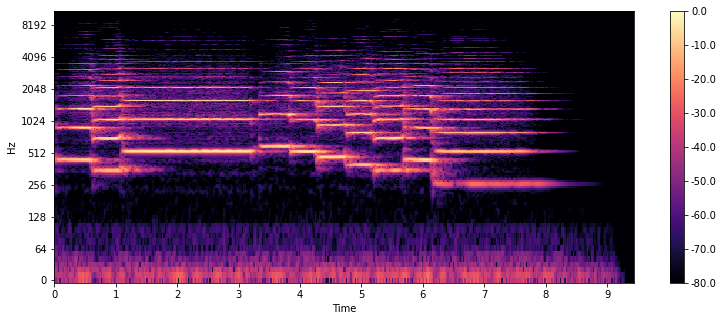

In [94]:
x , sr = librosa.load('../samples/trumpetFull.wav')
STFT = librosa.stft(x) # return two vectors: magnitude and phase
STFT_db = librosa.amplitude_to_db(abs(STFT), ref=np.max)
fig, ax = plt.subplots(figsize = (13, 5))
img = librosa.display.specshow(STFT_db,
                               y_axis='log',
                               x_axis='time', 
                               ax=ax)

fig.colorbar(img, ax = ax, format = f'%0.1f')

<h1 style = "font-size:3rem;color:orange">Autocorrelation</h1>

Correlation methods are using the periodic relation of the signal by measuring the difference $e(n)$, or error, between the input signal $x(n)$ and delayed input signal $x(n-\tau)$: 

\begin{equation}
    e(n) = x(n) - ax(n-\tau),
\end{equation}

where $a$ is a scalar to account for amplitude changes.\\\\


Getting the size of the error by squaring, yielding the objective function $J(a,\tau)$:

\begin{equation}
    J(a,\tau) = \sum_{n=\tau}^{N-1} |e(n)|^2.
\end{equation}

With autocorrelation, the objective function is rewriting:

\begin{align}
     J(a,\tau) &= \sum_{n=\tau}^{N-1} |e(n)|^2 \\
               &=\sum_{n=\tau}^{N-1} x^2(n) - \sum_{n=\tau}^{N-1}a^2x^2(x-\tau) -2aR(\tau),
\end{align}

with autocorrelation function $R(\tau) = \sum_{n=\tau}^{N-1}x(n)x(n-\tau)$, which needs to maximized in order to minimize the objective function: 

\begin{equation}
    \hat{\tau} = \operatorname*{argmax}_{\tau \in [\tau_{min}, \tau_{max}]} R(\tau).
\end{equation}


Code example autocorrelation:

In [122]:
def autocorrelation(data, minFreq, maxFreq, sr):    
    nData = len(data);
    minTau = int(max(1,np.ceil(1 / maxFreq)));        # Minimum period
    maxTau = int(min(nData,np.floor(1 / minFreq)));   # Maximum period
    nTau = int(maxTau - minTau);
    
    objectiveFunc = np.zeros(nTau);            # Objective funciton we want to minimize
    
    for tau in range(minTau,maxTau):
        xt = data[range(0,len(data)-1-tau)];               # Trimeed delayed input signal
        x = data[range(tau,len(data)-1)];                  # Trimmed input data
        
        autoCor = 0;
        
        for n in range(0,len(x)):
            autoCor = autoCor + (1/(nData-tau))*x[n]*xt[n]; # Using the autocorrelation function
        
        objectiveFunc[tau-minTau] = max(autoCor,0);         # Put the outcome into the objective function vec
    
    index = np.argmax(objectiveFunc);
    pitch = 1/(index+minTau) * sr;
    
    
    return pitch

<h1 style = "font-size:3rem;color:orange">Comb-filtering</h1>

Similar to autocorrelation, but more accurate as it also includes scalar $a$, that accounts for amplitude changes.
The difference, or error, between the signal and shifted signal is $e[n] = x[n] - ax[n-\tau]$

Then the objective function is obtained by squaring the error (finding the size) and going through a set of periods:

$J(a,\tau) = \sum_{n=\tau}^{N-1}e[n]^2$

Then the pitch can be obtained by minimizing the objective function: 

$\hat{\tau} = argmin \ J(a, \tau)$.

Finding $a$:

\begin{align}
     J(a,\tau) &= \sum_{n=\tau}^{N-1} |e(n)|^2 = \sum_{n=\tau}^{N-1} |x(n) - ax(n-\tau)|^2\\
               &=\sum_{n=\tau}^{N-1} x^2(n) + a^2\sum_{n=\tau}^{N-1}x^2(n-\tau) -2a\sum_{n=\tau}^{N-1}x(n)x(n-\tau) \\
      \frac{dJ}{da} &= 2a\sum_{n=\tau}^{N-1}x^2(n-\tau) -2\sum_{n=\tau}^{N-1}x(n)x(n-\tau).\\
      \frac{dJ}{da} &= 0 \Longrightarrow a = \frac{\sum_{n=\tau}^{N-1}x(n)x(n-\tau)}{\sum_{n=\tau}^{N-1}x^2(n-\tau)}.
\end{align}

Inserting $a$ into the objective function:

\begin{align}
   \hat{\tau} &= \operatorname*{argmin}_{\tau \in [\tau_{min}, \tau_{max}]} J(a,\tau)\\
    &= \operatorname*{argmin}_{\tau \in [\tau_{min}, \tau_{max}]} \left[ \sum_{n=\tau}^{N-1} x^2(n) -2 \frac{\sum_{n=\tau}^{N-1}x^2(n)x^2(n-\tau)}{\sum_{n=\tau}^{N-1}x^2(n-\tau)} + \frac{\sum_{n=\tau}^{N-1}x^2(n)x^4(n-\tau)}{\sum_{n=\tau}^{N-1}x^4(n-\tau)}\right]\\
    &= \operatorname*{argmin}_{\tau \in [\tau_{min}, \tau_{max}]} \left[ \sum_{n=\tau}^{N-1} x^2(n) - \frac{\left[\sum_{n=\tau}^{N-1}x(n)x(n-\tau)\right]^2}{\sum_{n=\tau}^{N-1}x^2(n-\tau)}\right].
\end{align}

Function for estimating pitch using comb-filtering: 

In [121]:
def comb_filtering(data, minFreq, maxFreq, sr):    
    nData = len(data);
    minTau = int(max(1,np.ceil(1 / maxFreq)));        # Minimum period
    maxTau = int(min(nData,np.floor(1 / minFreq)));   # Maximum period
    nTau = int(maxTau - minTau);
    
    objectiveFunc = np.zeros(nTau);            # Objective funciton we want to minimize
    
    for tau in range(minTau,maxTau):
        xt = data[range(0,len(data)-1-tau)];               # Trimeed delayed input signal
        x = data[range(tau,len(data)-1)];                  # Trimmed input data
        
        xSumSq = 0;   # Summed input signal squared
        xtSumSq = 0;  # Summed delayed input signal squared 
        xxtSum = 0;   # Summed input * delyed input
        
        for n in range(0,len(x)):
            xSumSq = xSumSq + x[n]*x[n];          # Summed input signal squared
            xtSumSq = xtSumSq + xt[n]*xt[n];      # Summed delayed input signal squared 
            xxtSum = xxtSum + x[n]*xt[n];         # Summed input * delayed input
        
        crosscor = xSumSq*xtSumSq
        
        #check if value is non-zero:
        if crosscor != 0:
            normCrossCor = (xxtSum / np.sqrt(crosscor));
        else:
            normCrossCor = 0 
            
        objectiveFunc[tau-minTau] = max(normCrossCor,0); # Put the outcome into the objective function vec
    
    index = np.argmax(objectiveFunc);
    pitch = 1/(index+minTau) * sr;
    
    return pitch

<h1 style = "font-size:3rem;color:orange">Harmonic Summation</h1>

 Based on the harmonicity of a signal:
    \begin{equation}
        e(n) = x(n) - \sum_{l= 1}^{L} A_l\cos{(\omega_0ln+\phi_l)}.
    \end{equation}
    
Yielding the objective function:

   \begin{align}
        J(\omega_0) &= \sum_{n=0}^{N-1}|e(n)|^2 = \frac{1}{2\pi}\int_{0}^{2\pi}|E(\omega_0)|^2dw\\
            &= \frac{1}{2\pi}\int_{0}^{2\pi}|X(\omega)|^2dw - \frac{2}{N}\sum_{l= 1}^{L}|X(\omega_0l)|^2.
    \end{align}
    Minimizing the objective function by maximizing the second term:
    \begin{equation}
        \hat{\omega_0}= \operatorname*{argmax}_{\omega_0} \sum_{l= 1}^{L}|X(\omega_0l)|^2
    \end{equation}

Function for estimating pitch using Harmonic Summation:

In [120]:
def harmonic_summation(data, minFreq, maxFreq, nHarmonics, sr):    
    nData = len(data);
    nDFT = 5 * nData * nHarmonics;                 # Size of the DFT (5 * signalLength * number of harmonics)
    X = np.fft.fft(data,nDFT);                     # Take DFT
    maxFreq = min(maxFreq, 1/(2*nHarmonics));      # Max frequency
    minDftIndex = int(np.ceil(nDFT*minFreq));           # Minimal fundamental frequency bin
    maxDftIndex = int(np.floor(nDFT*maxFreq));          # Maximal fundamental frequency bin
    nFrequencies = int(maxDftIndex - minDftIndex); 
    objectiveFunc = np.zeros(nFrequencies);
    
    for w in range(minDftIndex,maxDftIndex):
        for l in range(1,nHarmonics):
            objectiveFunc[w - minDftIndex] = objectiveFunc[w - minDftIndex] + abs(X[l*w])*abs(X[l*w]); # HS Estimater
    
    index = np.argmax(objectiveFunc);
    
    pitch = sr * ((index/nDFT) + minFreq);

    return pitch

<h1 style = "font-size:3rem;color:orange">Comparison</h1>

Break data into segments

In [123]:
min_freq = 100;                                        # Minimum frequency that can be estimated
max_freq = 1000;                                       # Maximum frequency that can be estimated
 
norm_min_freq = min_freq / sr;                         # Normalized min frequency            
norm_max_freq = max_freq / sr;                         # Normalized max frequency

overlap = 50;                                          # Percentage overlap from previous segment
nData = len(x);                                        # Total amount of samples
segmentLength =  100/1000;                              # Length of each segment in miliseconds
nSegmentLength = segmentLength * sr;                   # Segment Length in samples

nShift = int(round((1-overlap/100)*nSegmentLength));        # Segment shift in samples
number_of_segments = int(np.ceil((nData-nSegmentLength+1)/nShift));  # Total amount of segments                                   

Autocorrelation

In [124]:
iVector = list(range(1, int(nSegmentLength) + 1));      # Vector used for indexing
pitchVecAC = np.zeros(nData);                             # Vector containing the estimated pitch using Auto Correlation

for i in range(0,int(number_of_segments)):
    pitchVecAC[iVector] =  autocorrelation(x[iVector], norm_min_freq, norm_max_freq, sr);              # Estimate pitch using Auto Correlation
    iVector = [z+nShift for z in iVector];
    #print(f'Processing segment {i+1} of {number_of_segments}')

Comb-filtering

In [126]:
iVector = list(range(1, int(nSegmentLength) + 1));      # Vector used for indexing
pitchVecCF = np.zeros(nData);                             # Vector containing the estimated pitch using Auto Correlation

for i in range(0,int(number_of_segments)):
    pitchVecCF[iVector] =  comb_filtering(x[iVector], norm_min_freq, norm_max_freq, sr);              # Estimate pitch using Comb-filtering
    iVector = [z+nShift for z in iVector];
    #print(f'Processing segment {i+1} of {number_of_segments}')

Harmonic Summation

In [125]:
iVector = list(range(1, int(nSegmentLength) + 1));      # Vector used for indexing
pitchVecHS = np.zeros(nData);                             # Vector containing the estimated pitch using Auto Correlation

for i in range(0,int(number_of_segments)):
    pitchVecHS[iVector] =  harmonic_summation(x[iVector], norm_min_freq, norm_max_freq, 5, sr);   # Estimate pitch using Harmonic Summation
    iVector = [z+nShift for z in iVector];
   # print(f'Processing segment {i+1} of {number_of_segments}')

Plot the estimated pitch and compare to STFT

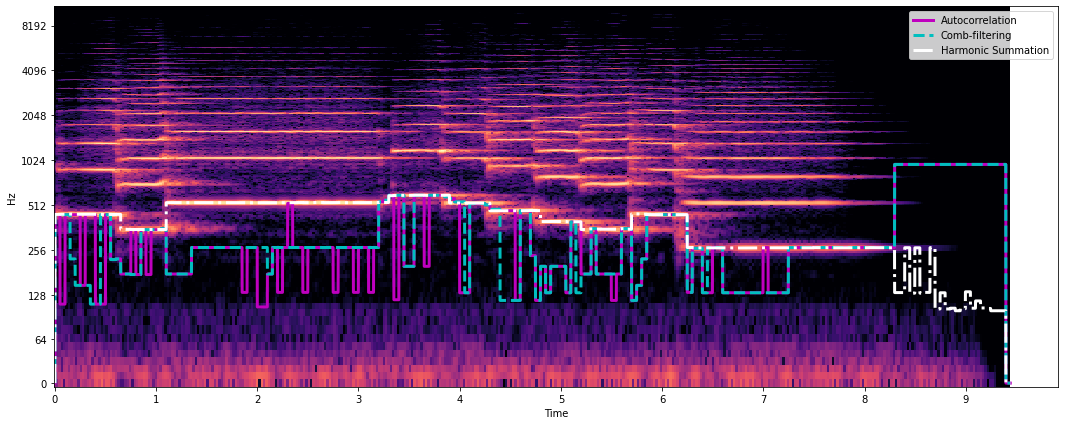

In [128]:
STFT = librosa.stft(x) # return two vectors: magnitude and phase
STFT_db = librosa.amplitude_to_db(abs(STFT), ref=np.max)
fig, ax = plt.subplots(figsize = (18, 7))
img = librosa.display.specshow(STFT_db,
                               y_axis='log',
                               x_axis='time', 
                               ax=ax)

pitch_norm = pitchVec * sr
timeVec = np.arange(0, nData/sr, 1/sr, dtype=np.float64)

plt.plot(timeVec, pitchVecAC, lw=3, color = 'm',  label = 'Autocorrelation')
plt.plot(timeVec, pitchVecCF, lw=3, color = 'c', linestyle='dashed', label = 'Comb-filtering')
plt.plot(timeVec, pitchVecHS, lw=3, color = 'w', linestyle='dashdot', label = 'Harmonic Summation')

plt.legend()
plt.show()